In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib inline

from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout

2023-06-08 16:23:23.256739: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import datetime as dt
import yfinance as yf

tickers = ["GLE.PA"]
df = yf.download(tickers,  start = "2019-01-04" , end = "2023-02-20")

[*********************100%***********************]  1 of 1 completed


In [3]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-04,27.754999,28.389999,27.594999,28.370001,18.108696,5800499
2019-01-07,28.510000,28.719999,28.094999,28.415001,18.137423,3562802
2019-01-08,28.405001,29.010000,28.299999,28.615000,18.265081,4077846
2019-01-09,28.830000,28.879999,28.295000,28.504999,18.194864,3707741
2019-01-10,28.320000,28.834999,28.180000,28.780001,18.370401,3522911
...,...,...,...,...,...,...
2023-02-13,26.290001,26.650000,26.084999,26.450001,24.552744,2836924
2023-02-14,26.160000,26.660000,26.115000,26.510000,24.608438,2793743
2023-02-15,26.334999,26.809999,26.264999,26.799999,24.877636,4458988


In [4]:
df = df.rename_axis('Date').reset_index()

In [5]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-04,27.754999,28.389999,27.594999,28.370001,18.108696,5800499
1,2019-01-07,28.510000,28.719999,28.094999,28.415001,18.137423,3562802
2,2019-01-08,28.405001,29.010000,28.299999,28.615000,18.265081,4077846
3,2019-01-09,28.830000,28.879999,28.295000,28.504999,18.194864,3707741
4,2019-01-10,28.320000,28.834999,28.180000,28.780001,18.370401,3522911


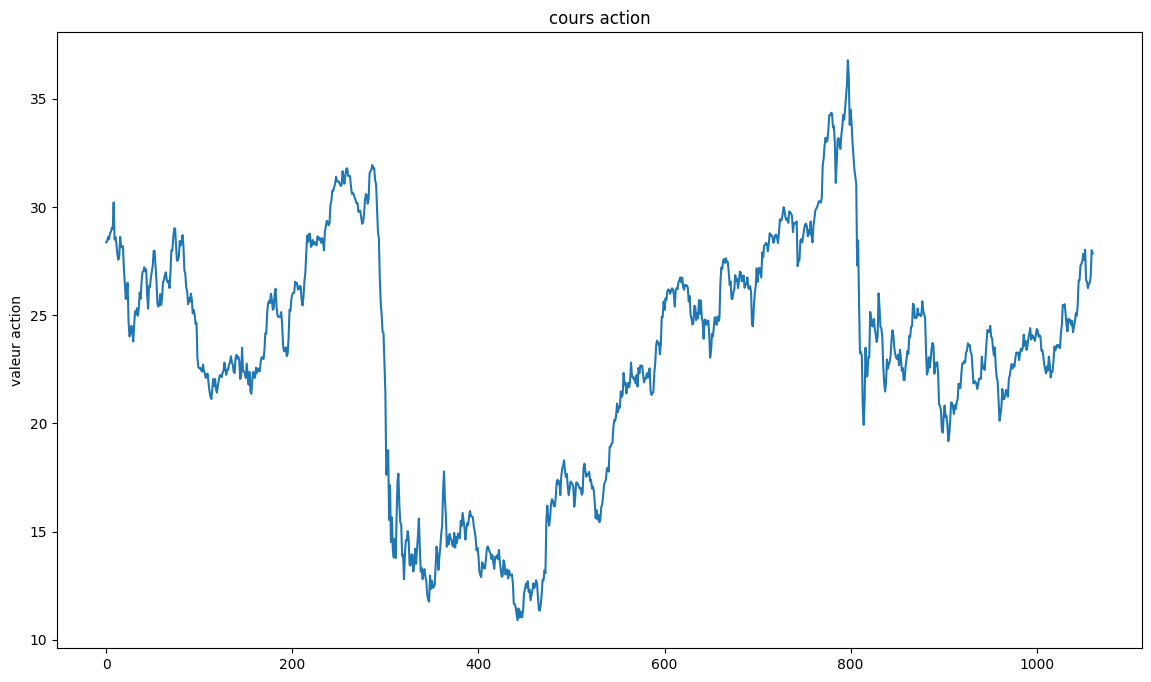

In [6]:
# visu évolution cours action 
df['Close'].plot(figsize=(14,8))
plt.title('cours action')
plt.ylabel('valeur action')
plt.show()

In [7]:
# transformation en array avec values puis redimensionnement df pour tensorflow
# la deuxième dimension est 1 car 1 seul feature ici, la valeur Close de l'action 
df = df['Close'].values
df = df.reshape(-1,1)
print(df.shape)

(1061, 1)


In [8]:
# dimension de la fenetre de temps utilisée
nbre_days = 30

In [9]:
# train et test data sets
# recouvrement de 'nbre_days' valeurs entre train et test data sets
dataset_train = np.array(df[:int(df.shape[0]*0.85)])
dataset_test = np.array(df[int(df.shape[0]*0.85)-nbre_days:])

In [10]:
# mise à l'échelle du train set
scaler = MinMaxScaler(feature_range=(0,1))
dataset_train = scaler.fit_transform(dataset_train)

In [11]:
# mise à l'échelle du test set
dataset_test = scaler.transform(dataset_test)
dataset_test[:3]

array([[0.54011438],
       [0.55673211],
       [0.54494511]])

In [12]:
# df.shape[0] est le nbre de lignes du dataset
# dans x on met les 'nbre_days' valeurs et dans y correspondant la 'nbre_days +1' ième valeur pour le training
def create_my_dataset(df):
    x = []
    y = []
    for i in range(nbre_days,df.shape[0]):
        x.append(df[i-nbre_days:i,0])
        y.append(df[i,0])
    x = np.array(x)
    y = np.array(y)
    return x,y

In [13]:
x_train,y_train = create_my_dataset(dataset_train)
x_train[:1]

array([[0.67498847, 0.67672753, 0.68445666, 0.68020559, 0.69083326,
        0.69373165, 0.70049472, 0.69952852, 0.74609677, 0.6800124 ,
        0.68407019, 0.67131706, 0.6537332 , 0.64387854, 0.6498686 ,
        0.68464993, 0.66629314, 0.66590667, 0.6680322 , 0.62745401,
        0.60214103, 0.5737363 , 0.5857165 , 0.60272069, 0.53335139,
        0.506879  , 0.51190293, 0.52581546, 0.51692693, 0.4977972 ]])

In [15]:
x_test,y_test = create_my_dataset(dataset_test)
x_test[:1]

array([[0.54011438, 0.55673211, 0.54494511, 0.54687745, 0.54339932,
        0.54397898, 0.56948524, 0.55248111, 0.54591132, 0.54011438,
        0.48098627, 0.43866902, 0.44485242, 0.46958574, 0.45142215,
        0.46475501, 0.48581701, 0.4952852 , 0.49045447, 0.44021489,
        0.45973101, 0.45393415, 0.46089041, 0.44002169, 0.38591744,
        0.38263258, 0.37528985, 0.33992893, 0.3350595 , 0.36466225]])

In [16]:
# redimensionnement nécessaire pour RNN LSTM
# x_train.shape
# la dernière dimension, ici 1 est le nbre de features 
#(957,50,1)
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_train.shape)
print(x_test.shape)

(871, 30, 1)
(160, 30, 1)


In [17]:
# modèle RNN LSTM
model = Sequential()
model.add(LSTM(units=16,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=16,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=16))
model.add(Dropout(0.2))
model.add(Dense(units=1))

2023-06-08 16:24:29.092897: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 16)            1152      
                                                                 
 dropout (Dropout)           (None, 30, 16)            0         
                                                                 
 lstm_1 (LSTM)               (None, 30, 16)            2112      
                                                                 
 dropout_1 (Dropout)         (None, 30, 16)            0         
                                                                 
 lstm_2 (LSTM)               (None, 16)                2112      
                                                                 
 dropout_2 (Dropout)         (None, 16)                0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [19]:
#model.compile(loss = 'mean_squared_error', optimizer='adam', metrics=['accuracy'])
model.compile(loss = 'mean_squared_error', optimizer='adam')

In [20]:
res = model.fit(x_train,y_train, epochs=30, batch_size=2, validation_split=0.1, verbose=1)
model.save(r'stock_prediction.h5')

Epoch 1/30
392/392 [==============================] - 12s 23ms/step - loss: 0.0220 - val_loss: 0.0132
Epoch 2/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0117 - val_loss: 0.0071
Epoch 3/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0096 - val_loss: 0.0057
Epoch 4/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0083 - val_loss: 0.0059
Epoch 5/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0069 - val_loss: 0.0068
Epoch 6/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0061 - val_loss: 0.0037
Epoch 7/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0059 - val_loss: 0.0033
Epoch 8/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0048 - val_loss: 0.0031
Epoch 9/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0044 - val_loss: 0.0029
Epoch 10/30
392/392 [==============================] - 8s 21ms/step - loss: 0.0040 - val_l

In [21]:
# fonction visu résultats
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()   

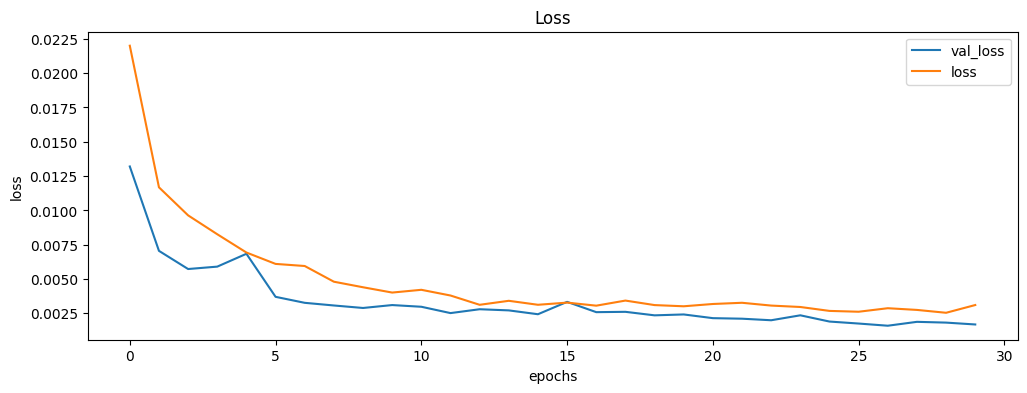

In [22]:
visualize_results(res)

In [23]:
model = load_model(r'stock_prediction.h5')

5/5 [==============================] - 1s 5ms/step
range(901, 1061)


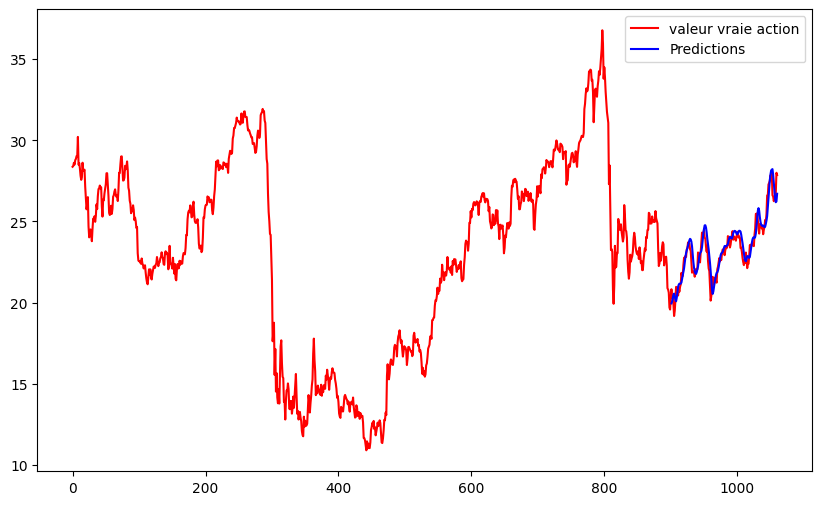

In [24]:
# prévisions sur x_test et visu prévisions 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig,ax = plt.subplots(figsize=(10,6))
plt.plot(df,color='red', label='valeur vraie action')
ax.plot(range(len(y_train)+nbre_days, len(y_train)+nbre_days+len(predictions)),predictions, color='blue',label='Predictions')
plt.legend()
print(range(len(y_train)+nbre_days,len(y_train)+nbre_days+len(predictions)))
# les prédictions suivent les tendances

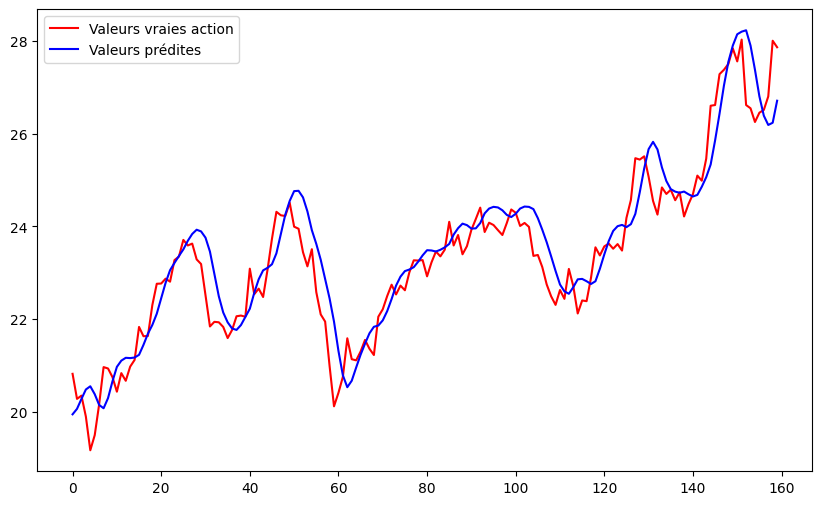

In [25]:
# zoom sur prévisions vs valeurs réelles
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(y_test_scaled, color='red',label='Valeurs vraies action')
plt.plot(predictions,color="blue",label = 'Valeurs prédites')
plt.legend();

In [ ]:
# Learning rate et Early stopping

In [26]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
# réduction du learning rate si pas de diminution de la validation loss au bout de 3 epoqs (patience=3) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.25,patience=3, min_lr=0.00001,verbose = 1)

In [27]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

In [28]:
import tensorflow

In [29]:
model = Sequential()
model.add(LSTM(units=64,return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.3))
model.add(LSTM(units=64))
model.add(Dropout(0.3))
model.add(Dense(units=1))

In [30]:
#optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.001)
# SGD pas du tout adapté dans ce cas
optimizer = tensorflow.keras.optimizers.SGD(learning_rate = 0.001)
model.compile(loss='mean_squared_error', optimizer=optimizer)

In [31]:
res = model.fit(x_train,y_train, epochs=100, batch_size=2, validation_split=0.2,
                callbacks=[reduce_lr, early_stop], shuffle=False, verbose=1)
model.save(r'stock_prediction.h5')

Epoch 1/100
348/348 [==============================] - 6s 13ms/step - loss: 0.0619 - val_loss: 0.0341 - lr: 0.0010
Epoch 2/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0267 - val_loss: 0.0261 - lr: 0.0010
Epoch 3/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0227 - val_loss: 0.0216 - lr: 0.0010
Epoch 4/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0206 - val_loss: 0.0186 - lr: 0.0010
Epoch 5/100
348/348 [==============================] - 4s 12ms/step - loss: 0.0167 - val_loss: 0.0167 - lr: 0.0010
Epoch 6/100
348/348 [==============================] - 4s 12ms/step - loss: 0.0151 - val_loss: 0.0140 - lr: 0.0010
Epoch 7/100
348/348 [==============================] - 4s 12ms/step - loss: 0.0135 - val_loss: 0.0134 - lr: 0.0010
Epoch 8/100
348/348 [==============================] - 4s 11ms/step - loss: 0.0120 - val_loss: 0.0121 - lr: 0.0010
Epoch 9/100
348/348 [==============================] - 4s 11ms/step - loss: 0.01

In [32]:
def visualize_results(results):
    history = results.history
    plt.figure(figsize=(12,4))
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss','loss'])
    plt.title('Loss')
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.show()     

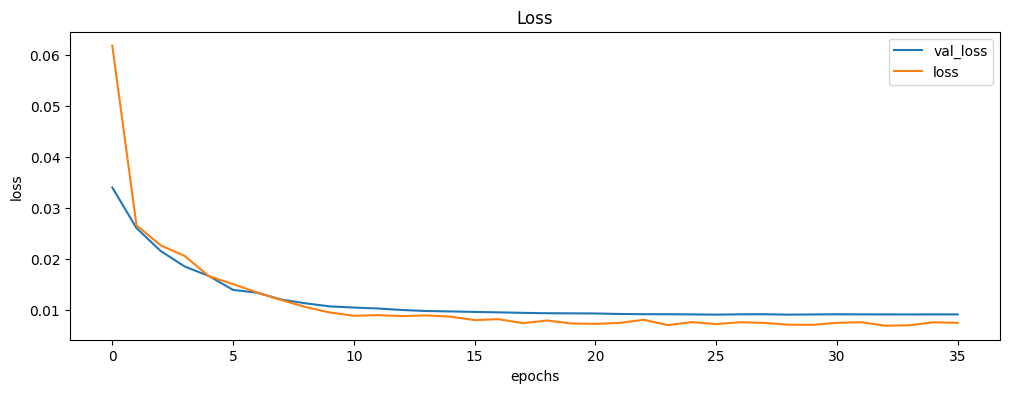

In [33]:
visualize_results(res)

5/5 [==============================] - 1s 8ms/step
range(901, 1061)


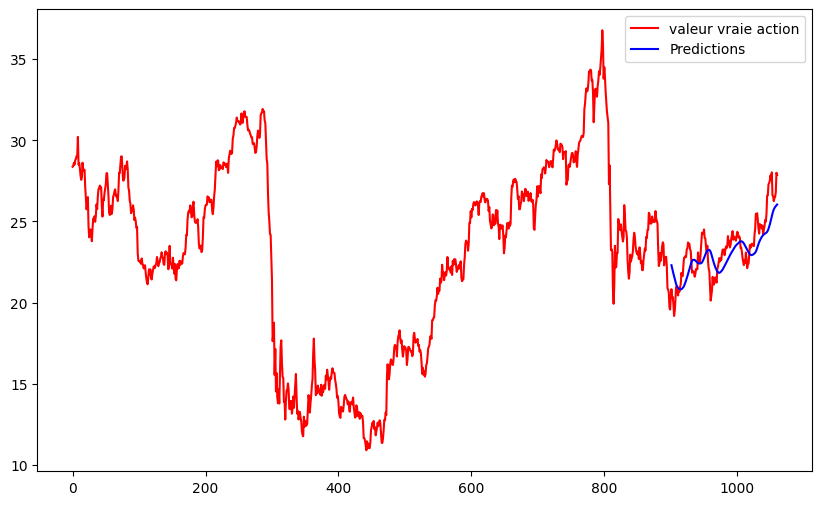

In [34]:
# prévisions sur x_test et visu prévisions 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

fig,ax = plt.subplots(figsize=(10,6))
plt.plot(df,color='red', label='valeur vraie action')
ax.plot(range(len(y_train)+nbre_days, len(y_train)+nbre_days+len(predictions)),predictions, color='blue',label='Predictions')
plt.legend()
print(range(len(y_train)+nbre_days,len(y_train)+nbre_days+len(predictions)))
# les prédictions suivent les tendances

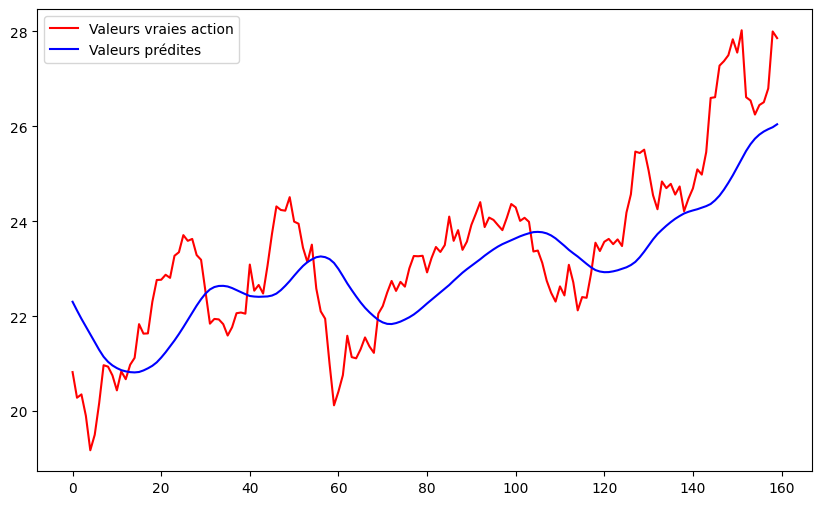

In [35]:
# zoom sur prévisions vs valeurs réelles
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1,1))

fig,ax = plt.subplots(figsize=(10,6))
ax.plot(y_test_scaled, color='red',label='Valeurs vraies action')
plt.plot(predictions,color="blue",label = 'Valeurs prédites')
plt.legend()